In [124]:
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
import numpy as np
import pandas as pd        
from sklearn.model_selection import train_test_split
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [125]:
eur_usd = pd.DataFrame(pd.read_csv("C:\\Users\\2003l\\Downloads\\EUR_USD Dati Storici.csv")) 
gbp_usd = pd.DataFrame(pd.read_csv("C:\\Users\\2003l\\Downloads\\GBP_USD Dati Storici.csv"))
eur_usd

,Data,Ultimo,Apertura,Massimo,Minimo,Vol.,Var. %
0,13.12.2024,"1,0472","1,0474","1,0481","1,0453",NaN,"0,04%"
1,12.12.2024,"1,0467","1,0496","1,0531","1,0463",NaN,"-0,26%"
2,11.12.2024,"1,0494","1,0528","1,0540","1,0480",NaN,"-0,30%"
3,10.12.2024,"1,0526","1,0555","1,0568","1,0499",NaN,"-0,25%"
4,09.12.2024,"1,0552","1,0564","1,0595","1,0532",NaN,"-0,15%"
...,...,...,...,...,...,...,...
1301,19.12.2019,"1,1120","1,1113","1,1145","1,1107",NaN,"0,08%"
1302,18.12.2019,"1,1111","1,1150","1,1156","1,1110",NaN,"-0,34%"
1303,17.12.2019,"1,1149","1,1143","1,1176","1,1128",NaN,"0,06%"
1304,16.12.2019,"1,1142","1,1122","1,1159","1,1122",NaN,"0,21%"


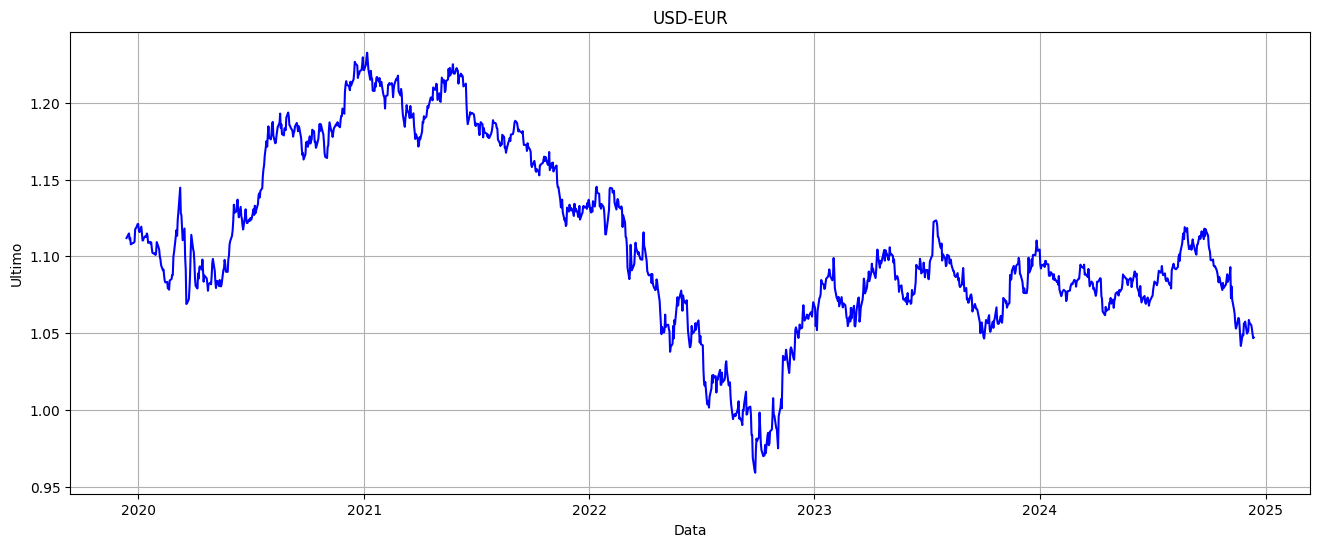

In [126]:
eur_usd["Data"] = pd.to_datetime(eur_usd["Data"], format="%d.%m.%Y")
eur_usd = eur_usd.sort_values(by="Data", ascending=True).reset_index(drop=True)

eur_usd["Ultimo"] = eur_usd["Ultimo"].str.replace(",", ".").astype(float)

data1 = eur_usd[['Data', 'Ultimo']].copy()
data1.set_index('Data', inplace=True)

plt.figure(figsize=(16, 6))
plt.plot(eur_usd['Data'], eur_usd['Ultimo'], marker='', linestyle='-', color='b')
plt.xlabel('Data')
plt.ylabel('Ultimo')
plt.title('USD-EUR')
plt.grid()
plt.show()


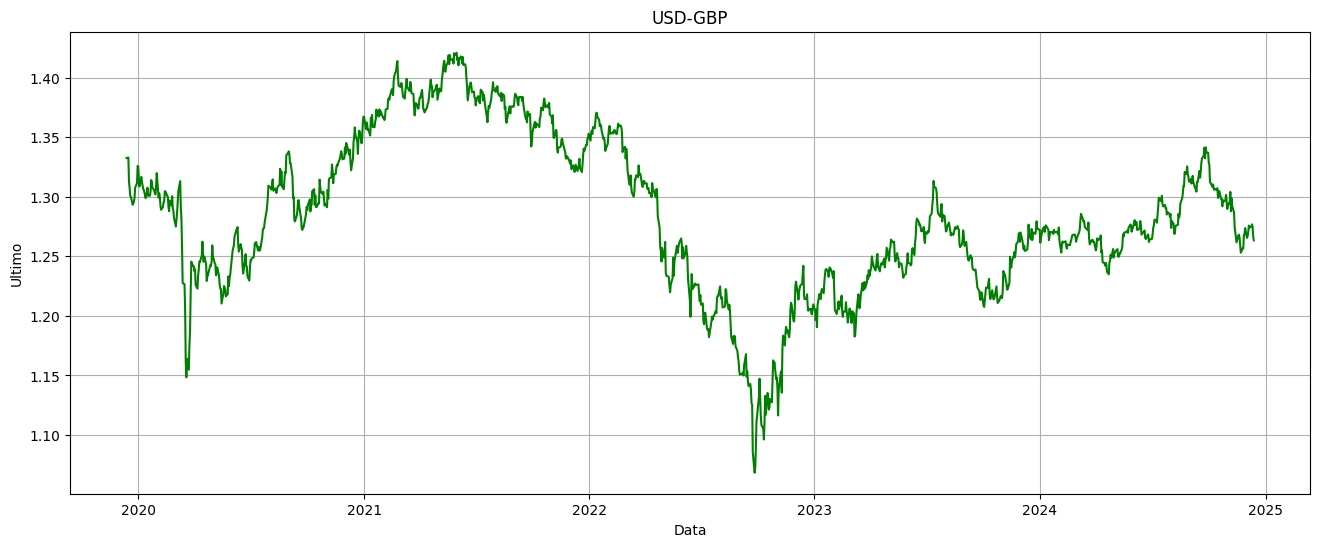

In [127]:
gbp_usd["Data"] = pd.to_datetime(gbp_usd["Data"], format="%d.%m.%Y")
gbp_usd = gbp_usd.sort_values(by="Data", ascending=True).reset_index(drop=True)

gbp_usd["Ultimo"] = gbp_usd["Ultimo"].str.replace(",", ".").astype(float)

data2 = gbp_usd[['Data', 'Ultimo']].copy()
data2.set_index('Data', inplace=True)

plt.figure(figsize=(16, 6))
plt.plot(gbp_usd['Data'], gbp_usd['Ultimo'], marker='', linestyle='-', color='g')
plt.xlabel('Data')
plt.ylabel('Ultimo')
plt.title('USD-GBP')
plt.grid()
plt.show()

c:\Users\2003l\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1115/1115 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - loss: 0.0138
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 310ms/step


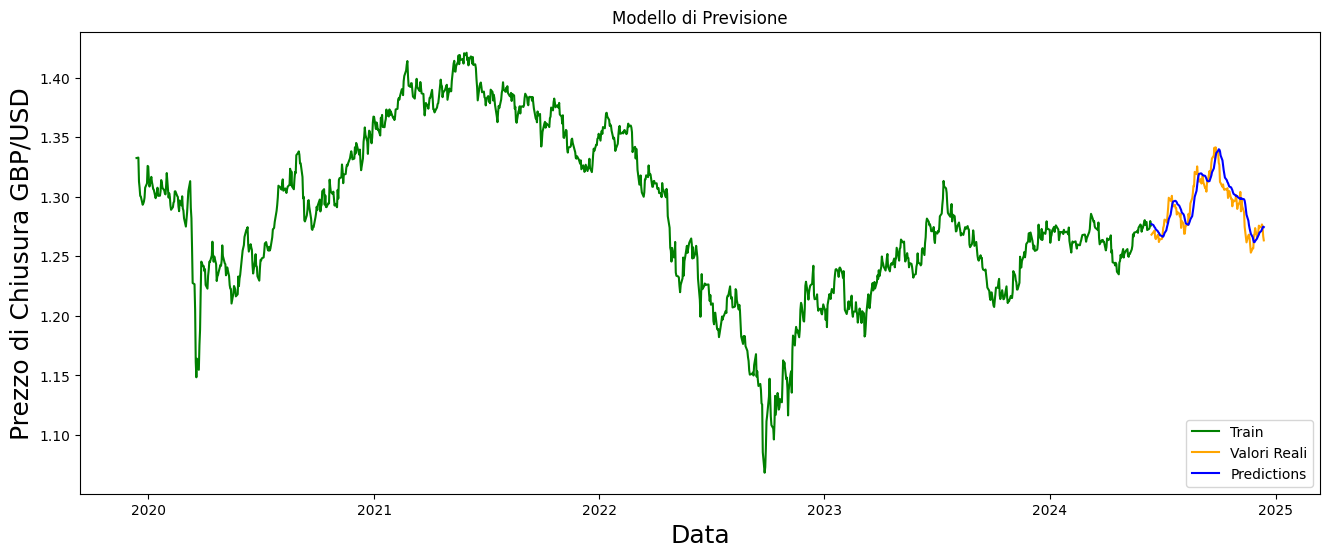

In [128]:
# Suddivisione in train / test
training_data_len = int(len(data2) * 0.90)

train_df = data2.iloc[:training_data_len].copy()
test_df  = data2.iloc[training_data_len:].copy()

# Scaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_df[['Ultimo']])
scaled_test = scaler.transform(test_df[['Ultimo']])

# Sequenze per il TRAINING

x_train, y_train = [], []

for i in range(60, len(scaled_train)):
    x_train.append(scaled_train[i-60:i, 0])
    y_train.append(scaled_train[i, 0])

# Convertiamo in numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


# Sequenze per il TEST

test_input = np.concatenate((scaled_train[-60:], scaled_test), axis=0)

x_test = []
for i in range(60, len(test_input)):
    x_test.append(test_input[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = test_df['Ultimo'].values


# Creazione e addestramento del modello

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dense(25,activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Esempio di training
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Previsione sul test set

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

valid2 = test_df.copy()
valid2['Predictions'] = predictions  

plt.figure(figsize=(16,6))
plt.title('Modello di Previsione')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Prezzo di Chiusura GBP/USD', fontsize=18)


plt.plot(train_df.index, train_df['Ultimo'], label='Train', color='green')
plt.plot(valid2.index, valid2['Ultimo'], label='Valori Reali', color='orange')
plt.plot(valid2.index, valid2['Predictions'], label='Predictions', color='blue')

plt.legend(loc='lower right')
plt.show()

USD EUR


c:\Users\2003l\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1115/1115 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - loss: 0.0089
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step


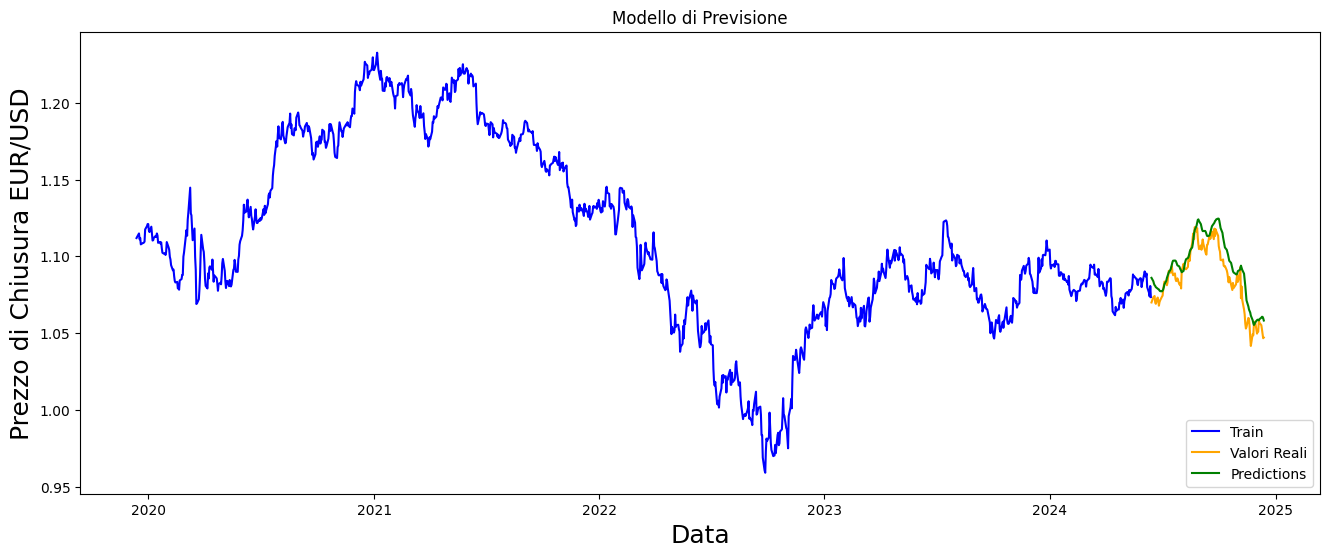

In [ ]:
# Suddivisione in train / test

training_data_len = int(len(data1) * 0.90)
train_df = data1.iloc[:training_data_len].copy()
test_df = data1.iloc[training_data_len:].copy()

# Scaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_df[['Ultimo']])
scaled_test = scaler.transform(test_df[['Ultimo']])

# Sequenze per il TRAINING

x_train, y_train = [], []

for i in range(60, len(scaled_train)):
    x_train.append(scaled_train[i-60:i, 0])
    y_train.append(scaled_train[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


# Sequenze per il TEST

test_input = np.concatenate((scaled_train[-60:], scaled_test), axis=0)

x_test = []
for i in range(60, len(test_input)):
    x_test.append(test_input[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = test_df['Ultimo'].values


# Creazione e addestramento del modello LSTM

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Previsioni sui dati di test

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


valid1 = test_df.copy()
valid1['Predictions'] = predictions  

plt.figure(figsize=(16,6))
plt.title('Modello di Previsione')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Prezzo di Chiusura EUR/USD', fontsize=18)
plt.plot(train_df.index, train_df['Ultimo'], label='Train', color='blue')
plt.plot(valid1.index, valid1['Ultimo'], label='Valori Reali', color='orange')
plt.plot(valid1.index, valid1['Predictions'], label='Predictions', color='green')
plt.legend(loc='lower right')
plt.show()


In [130]:
mae2 = mean_absolute_error(valid2["Ultimo"].dropna(), valid2["Predictions"].dropna())
mse2 = mean_squared_error(valid2["Ultimo"].dropna(), valid2["Predictions"].dropna())
r22 = r2_score(valid2["Ultimo"].dropna(), valid2["Predictions"].dropna())
rmse2= np.sqrt(mse2)
print("GBP_USD")
print(f"RMSE: {rmse2}")
print(f"MAE: {mae2}")
print(f"MSE: {mse2}")
print(f"R^2: {r22}")

mae1 = mean_absolute_error(valid1["Ultimo"].dropna(), valid1["Predictions"].dropna())
mse1 = mean_squared_error(valid1["Ultimo"].dropna(), valid1["Predictions"].dropna())
r21 = r2_score(valid1["Ultimo"].dropna(), valid1["Predictions"].dropna())
rmse1= np.sqrt(mse1)
print("EUR_USD")
print(f"RMSE: {rmse1}")
print(f"MAE: {mae1}")
print(f"MSE: {mse1}")
print(f"R^2: {r21}")

GBP_USD
RMSE: 0.010175492627888881
MAE: 0.00844583085475077
MSE: 0.00010354065022022097
R^2: 0.775683160355765
EUR_USD
RMSE: 0.01054922316553609
MAE: 0.008686273462717773
MSE: 0.0001112861093962833
R^2: 0.7291743505692445


Epoch 1/50


c:\Users\2003l\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 0.0661
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0027
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0019
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0018
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0018
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0015
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0016
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - loss: 0.0014
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0014
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.0013
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0012
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0012
Epoch 13/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0013
Epoch 14/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0012
Epoch 15/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0012
Epoch 16/50
3

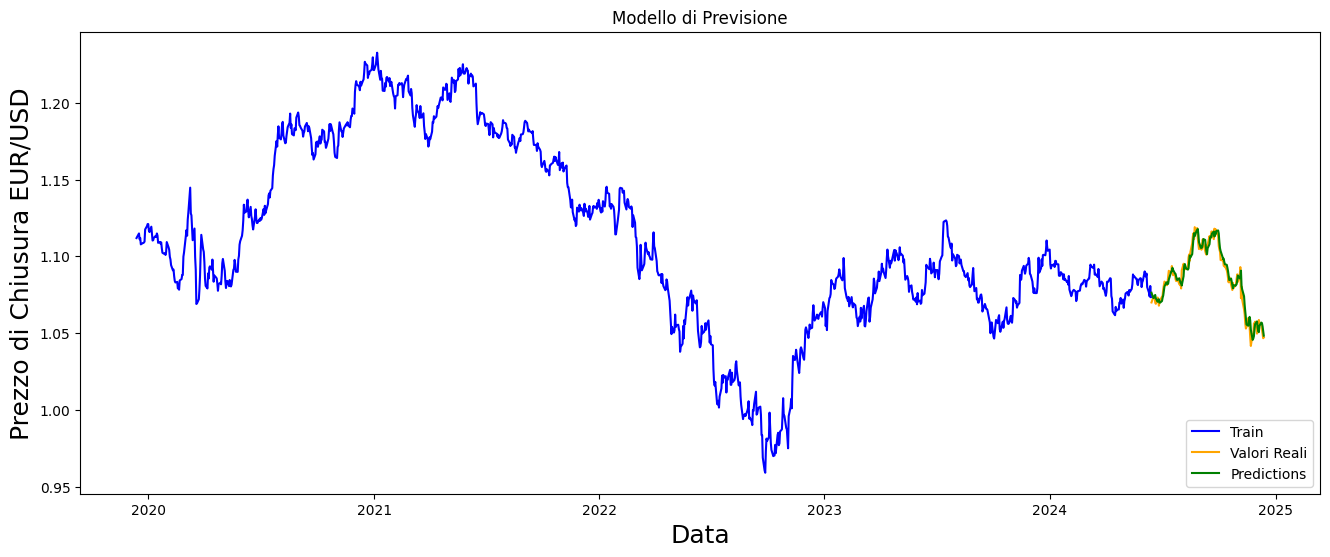

In [ ]:
# Suddivisione in train / test 

training_data_len = int(len(data1) * 0.90)

train_df = data1.iloc[:training_data_len].copy()
test_df  = data1.iloc[training_data_len:].copy()


# Scaler 

scaler1 = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler1.fit_transform(train_df[['Ultimo']])
scaled_test = scaler1.transform(test_df[['Ultimo']])


# Sequenze per il TRAINING

x_train1, y_train = [], []

for i in range(60, len(scaled_train)):  
    x_train1.append(scaled_train[i-60:i, 0])  
    y_train.append(scaled_train[i, 0])  


x_train1, y_train = np.array(x_train1), np.array(y_train)
x_train1 = np.reshape(x_train1, (x_train1.shape[0], x_train1.shape[1], 1))


# Sequenze per il TEST 

test_input = np.concatenate((scaled_train[-60:], scaled_test), axis=0)

x_test, y_test = [], test_df['Ultimo'].values
for i in range(60, len(test_input)):  
    x_test.append(test_input[i-60:i, 0])  

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


# Creazione del modello LSTM

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(x_train1.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compilazione del modello
model.compile(optimizer='adam', loss='mean_squared_error')

# Early Stopping per evitare overfitting
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Addestramento del modello
model.fit(x_train1, y_train, batch_size=32, epochs=50, callbacks=[early_stop])


# Previsioni sui dati di test
predictions1 = model.predict(x_test)
predictions1 = scaler1.inverse_transform(predictions1)



valid1 = test_df.copy()
valid1['Predictions'] = predictions1  


plt.figure(figsize=(16,6))
plt.title('Modello di Previsione')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Prezzo di Chiusura EUR/USD', fontsize=18)
plt.plot(train_df.index, train_df['Ultimo'], label='Train', color='blue')
plt.plot(valid1.index, valid1['Ultimo'], label='Valori Reali', color='orange')
plt.plot(valid1.index, valid1['Predictions'], label='Predictions', color='green')
plt.legend(loc='lower right')
plt.show()


c:\Users\2003l\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 0.0470
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0022
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0026
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0019
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0020
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0019
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0018
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0016
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0015
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0013
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0013
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0013
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 9.8261e-04
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0011
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0013

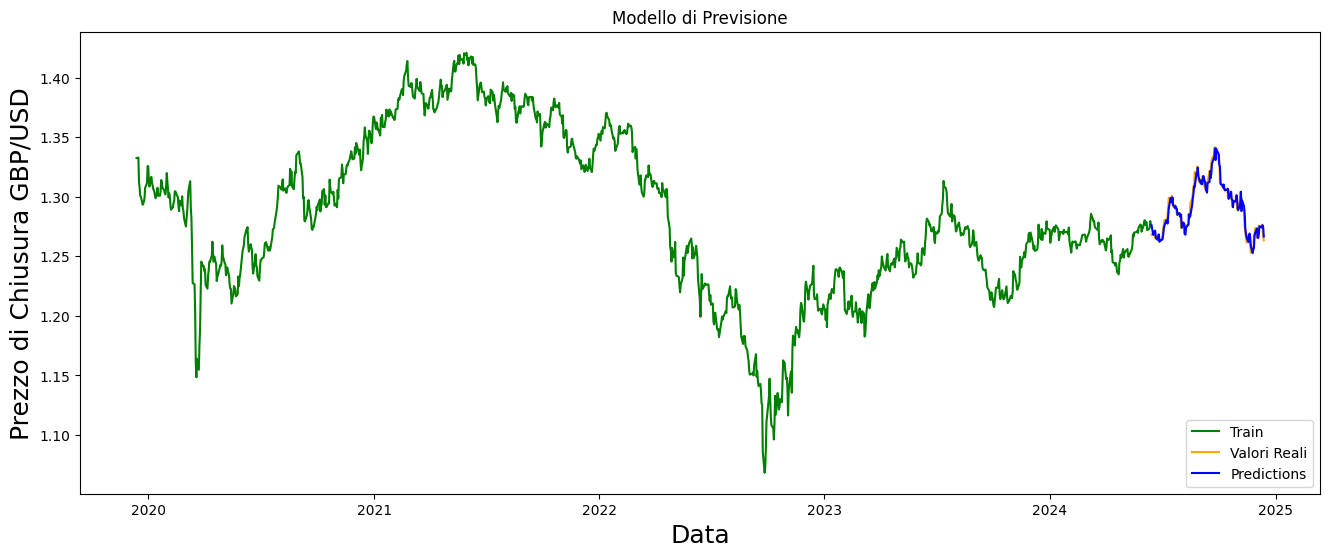

In [134]:
# Suddivisione in train / test

training_data_len = int(len(data2) * 0.90)

train_df = data2.iloc[:training_data_len].copy()
test_df  = data2.iloc[training_data_len:].copy()


# Scaler

scaler2 = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler2.fit_transform(train_df[['Ultimo']])
scaled_test = scaler2.transform(test_df[['Ultimo']])


# Sequenze per il TRAINING

x_train2, y_train = [], []

for i in range(60, len(scaled_train)):  
    x_train2.append(scaled_train[i-60:i, 0]) 
    y_train.append(scaled_train[i, 0])  


x_train2, y_train = np.array(x_train2), np.array(y_train)

x_train2 = np.reshape(x_train2, (x_train2.shape[0], x_train2.shape[1], 1))


# Sequenze per il TEST 

test_input = np.concatenate((scaled_train[-60:], scaled_test), axis=0)

x_test, y_test = [], test_df['Ultimo'].values
for i in range(60, len(test_input)):  
    x_test.append(test_input[i-60:i, 0])  


x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


# Creazione del modello LSTM

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(x_train2.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compilazione del modello
model.compile(optimizer='adam', loss='mean_squared_error')

# Early Stopping per evitare overfitting
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Addestramento del modello
model.fit(x_train2, y_train, batch_size=16, epochs=50, callbacks=[early_stop])


# Previsioni sui dati di test

predictions2 = model.predict(x_test)
predictions2 = scaler2.inverse_transform(predictions2)


valid2 = test_df.copy()
valid2['Predictions'] = predictions2  


plt.figure(figsize=(16,6))
plt.title('Modello di Previsione')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Prezzo di Chiusura GBP/USD', fontsize=18)
plt.plot(train_df.index, train_df['Ultimo'], label='Train', color='green')
plt.plot(valid2.index, valid2['Ultimo'], label='Valori Reali', color='orange')
plt.plot(valid2.index, valid2['Predictions'], label='Predictions', color='blue')
plt.legend(loc='lower right')
plt.show()


In [133]:
mae2 = mean_absolute_error(valid2["Ultimo"].dropna(), valid2["Predictions"].dropna())
mse2 = mean_squared_error(valid2["Ultimo"].dropna(), valid2["Predictions"].dropna())
r22 = r2_score(valid2["Ultimo"].dropna(), valid2["Predictions"].dropna())
rmse2= np.sqrt(mse2)
print("GBP_USD")
print(f"RMSE: {rmse2}")
print(f"MAE: {mae2}")
print(f"MSE: {mse2}")
print(f"R^2: {r22}")

mae1 = mean_absolute_error(valid1["Ultimo"].dropna(), valid1["Predictions"].dropna())
mse1 = mean_squared_error(valid1["Ultimo"].dropna(), valid1["Predictions"].dropna())
r21 = r2_score(valid1["Ultimo"].dropna(), valid1["Predictions"].dropna())
rmse1= np.sqrt(mse1)
print("EUR_USD")
print(f"RMSE: {rmse1}")
print(f"MAE: {mae1}")
print(f"MSE: {mse1}")
print(f"R^2: {r21}")

GBP_USD
RMSE: 0.005833759590807071
MAE: 0.0045885249567395835
MSE: 3.403275096333348e-05
R^2: 0.926269352913496
EUR_USD
RMSE: 0.004500495119564904
MAE: 0.0035904405593872113
MSE: 2.0254456321227518e-05
R^2: 0.9507087963015219
